# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size)
        print(actions)# select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Import necessary packages

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Define Actor model

In [8]:
# function to initialize weights of hidden layers
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units= 128, use_batchn = False):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.use_batchn = use_batchn
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        if self.use_batchn:
            self.bn0 = nn.BatchNorm1d(state_size)
            self.bn1 = nn.BatchNorm1d(fc1_units)
            self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()

    def reset_parameters(self):        
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        #self.fc1.bias.data.fill_(0.1)
        #self.fc2.bias.data.fill_(0.1)
        #self.fc3.bias.data.fill_(0.1)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if self.use_batchn:
            x = self.bn0(state)
            x = F.relu(self.bn1(self.fc1(x)))
            x = F.relu(self.bn2(self.fc2(x)))
            x = torch.tanh(self.fc3(x))
        else:
            x = F.relu(self.fc1(state))
            x = F.relu(self.fc2(x))
            x = torch.tanh(self.fc3(x))
            
        return x

## Define Critic

In [9]:
class Critic_old(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128, use_batchn = False):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.use_batchn = use_batchn
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        if self.use_batchn:
            self.bn0 = nn.BatchNorm1d(state_size)
            #self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):     
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        #self.fcs1.bias.data.fill_(0.1)
        #self.fc2.bias.data.fill_(0.1)
        #self.fc3.bias.data.fill_(0.1)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if self.use_batchn:
            x = self.bn0(state)
            xs = F.relu(self.fcs1(state))
            x = torch.cat((xs, action), dim =1)
            x = F.relu(self.fc2(x))
        else:
            xs = F.relu(self.fcs1(state))
            x = torch.cat((xs, action), dim = 1)
            x = F.relu(self.fc2(x))
        
        return self.fc3(x)

In [10]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Define Replay Buffer

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
    
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define agent

In [12]:
# Define agent hyperparameters
BUFFER_SIZE = int(5e5)  # replay buffer size
BATCH_SIZE = 64        # minibatch size
GAMMA = 0.98           # discount factor
TAU = 5e-3             # for soft update of target parameters
LR_ACTOR = 1e-3        # learning rate of the actor 
LR_CRITIC = 1e-3      # learning rate of the critic
WEIGHT_DECAY = 0.00        # L2 weight decay
UPDATE_TARGET_FREQ = 1
retrain = False

# check if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# define agent

BUFFER_SIZE = int(5e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0     # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process for each agent
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        if self.num_agents > 1:
            for agent in range(self.num_agents):
                self.memory.add(states[agent,:], actions[agent,:], rewards[agent], next_states[agent,:], dones[agent])
        else:
            self.memory.add(states, actions, rewards, next_states, dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        acts = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            if self.num_agents > 1:
                for agent in range(self.num_agents):
                    acts[agent,:] = self.actor_local(state[agent,:]).cpu().data.numpy()
            else:
                acts[0,:] = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            acts += self.noise.sample()
        return np.clip(acts, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Define noise

In [13]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.01):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        #self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

## Define runner function

In [14]:
#runner
def ddpg(n_agents, n_episodes=5000, max_t=30000, print_every=100):
    scores_deque = deque(maxlen=(print_every))
    agents = [agent_1, agent_2]
    #states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(n_agents) 
    scores_global=[]
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations
        states = np.reshape(states, (1, 48))
        scores = np.zeros(n_agents)      
        for a in agents:
            a.reset()
        average = 0
        step = 0
        while True:
            #actions = np.concat(agent.act(states)
            actions_1 = agent_1.act(states, add_noise=True)
            actions_2 = agent_2.act(states, add_noise=True)
            actions = np.concatenate((actions_1, actions_2), axis=0) 
            actions = np.reshape(actions, (1, 4))
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations 
            next_states = np.reshape(next_states, (1, 48))# get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done # see if episode finished

            agent_1.step(states, actions_1, rewards[0], next_states, dones[0])
            agent_2.step(states, actions_2, rewards[1], next_states, dones[1])
            scores += rewards                       # update the score (for each agent)
            states = next_states
            step +=1
            if np.any(dones):                                  # exit loop if episode finished
                break     
         
        score = np.max(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}\tMax: {:.2f}\tsteps: {}'.format(i_episode, score_average, scores, np.max(scores_global), step),end="")
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1_new.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1_new.pth')
        torch.save(agent_2.actor_local.state_dict(), 'checkpoint_actor_2_new.pth')
        torch.save(agent_2.critic_local.state_dict(), 'checkpoint_critic_2_new.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=0.9:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            
    return scores_global, scores_deque        
        

In [15]:
n_agents = 2
agent_1 = Agent(state_size*2, action_size,1, 1234)
agent_2 = Agent(state_size*2, action_size,1, 1234)


#scores = ddpg_one()
scores, scores_deque = ddpg(n_agents)

Episode 100	Average Score: 0.00	Score: [-0.01  0.  ]	Max: 0.10	steps: 14
Episode 200	Average Score: 0.01	Score: [ 0.   -0.01]	Max: 0.10	steps: 15
Episode 300	Average Score: 0.00	Score: [-0.01  0.  ]	Max: 0.10	steps: 15
Episode 400	Average Score: 0.04	Score: [ 0.   -0.01]	Max: 0.20	steps: 14
Episode 500	Average Score: 0.05	Score: [ 0.   -0.01]	Max: 0.20	steps: 13
Episode 600	Average Score: 0.07	Score: [-0.01  0.  ]	Max: 0.20	steps: 156
Episode 700	Average Score: 0.09	Score: [ 0.1  -0.01]	Max: 0.50	steps: 3050	steps: 213
Episode 800	Average Score: 0.10	Score: [ 0.    0.09]	Max: 0.50	steps: 309
Episode 900	Average Score: 0.25	Score: [ 0.40000001  0.29      ]	Max: 2.50	steps: 146
Episode 1000	Average Score: 0.59	Score: [ 0.1  -0.01]	Max: 2.60	steps: 500	steps: 2831
Episode 1100	Average Score: 0.60	Score: [ 0.    0.09]	Max: 2.60	steps: 2960	steps: 3191
Episode 1200	Average Score: 0.51	Score: [ 2.60000004  2.50000004]	Max: 2.60	steps: 1001
Episode 1300	Average Score: 0.48	Score: [ 1.30000002

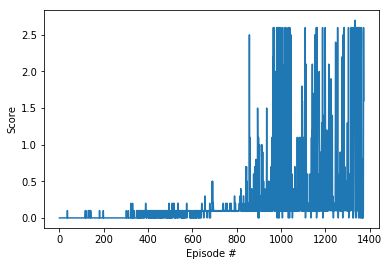

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("Plot of results_solution")
plt.show()

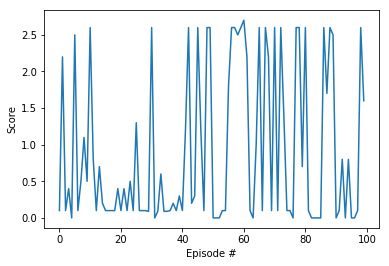

In [17]:
# plot the last 100 scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_deque)), scores_deque)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("Plot of last 100 episodes")
plt.show()

## Save files to .zip

In [18]:
!tar cvfz Solution.tar.gz *

Plot of last 100 episodes.png
Plot of results_solution.png
Report_.ipynb
Tennis.ipynb
checkpoint_actor_1_new.pth
checkpoint_actor_2_new.pth
checkpoint_critic_1_new.pth
checkpoint_critic_2_new.pth
ddpgActor1_Model.pth
ddpgActor2_Model.pth
ddpgCritic1_Model.pth
ddpgCritic2_Model.pth
python/
python/tests/
python/tests/test_ppo.py
python/tests/test_unitytrainers.py
python/tests/mock_communicator.py
python/tests/test_unityagents.py
python/tests/test_bc.py
python/tests/__init__.py
python/communicator_objects/
python/communicator_objects/unity_rl_input_pb2.py
python/communicator_objects/agent_action_proto_pb2.py
python/communicator_objects/unity_rl_initialization_output_pb2.py
python/communicator_objects/environment_parameters_proto_pb2.py
python/communicator_objects/resolution_proto_pb2.py
python/communicator_objects/unity_input_pb2.py
python/communicator_objects/engine_configuration_proto_pb2.py
python/communicator_objects/unity_rl_initialization_input_pb2.py
python/communicator_objects/com